In [43]:
import pandas as pd
import ta
import os
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, chi2,\
  mutual_info_regression, SelectKBest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import q_stat
from statsmodels.tsa.stattools import adfuller


os.chdir("../")

In [2]:
df = pd.read_parquet('data/bronze/crypto_stock_bronze_btc.parquet')

In [3]:
df.head()

,last_close,last_open,last_max,last_min,volume,date
0,314.890015,318.239990,321.359985,313.540009,12820,2015-01-01
1,315.209991,314.890015,316.399994,313.079987,14729,2015-01-02
2,287.130005,315.209991,315.829987,284.890015,47366,2015-01-03
3,264.720001,287.130005,289.940002,255.869995,88769,2015-01-04
4,274.839996,264.720001,278.320007,262.890015,54993,2015-01-05


In [4]:
df_features_indicators = ta.add_all_ta_features(df, open="last_open", high="last_max", low="last_min", close="last_max", volume="volume")


In [5]:
df_features_indicators

,last_close,last_open,last_max,last_min,volume,date,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,314.890015,318.239990,321.359985,313.540009,12820,2015-01-01,1.282000e+04,12820,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,315.209991,314.890015,316.399994,313.079987,14729,2015-01-02,2.754900e+04,-1909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.543438,-1.555473,-1.543438
2,287.130005,315.209991,315.829987,284.890015,47366,2015-01-03,7.491500e+04,-49275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.180154,-0.180316,-1.720811
3,264.720001,287.130005,289.940002,255.869995,88769,2015-01-04,1.636840e+05,-138044,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.197443,-8.553004,-9.777192
4,274.839996,264.720001,278.320007,262.890015,54993,2015-01-05,2.186770e+05,-193037,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.007724,-4.090246,-13.393073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,51722.722656,51572.050781,51952.046875,51299.015625,23609,2024-02-25,6.171862e+10,-11616954096,1.0,9.346124e+06,...,3.984995,4.376313,-0.391318,-10.584814,-3.772004,-6.812811,52296.552057,0.507171,0.505889,16066.308577
3343,54495.066406,51722.722656,54899.093750,50925.242188,78054,2024-02-26,6.171870e+10,-11616876042,1.0,4.087222e+07,...,4.220653,4.345181,-0.124528,-3.894453,-3.796494,-0.097960,52535.541291,5.672629,5.517572,16983.363285
3344,57056.164062,54491.109375,57555.238281,54463.964844,100477,2024-02-27,6.171880e+10,-11616775565,1.0,7.315925e+07,...,4.753221,4.426789,0.326432,4.255833,-2.186028,6.441862,53598.303062,4.838230,4.724831,17809.895726
3345,62467.597656,57048.675781,63915.335938,56704.945312,173640,2024-02-28,6.171897e+10,-11616601925,1.0,2.204747e+08,...,6.040489,4.749529,1.290960,18.174947,1.886167,16.288780,56707.945246,11.050424,10.481418,19789.015077


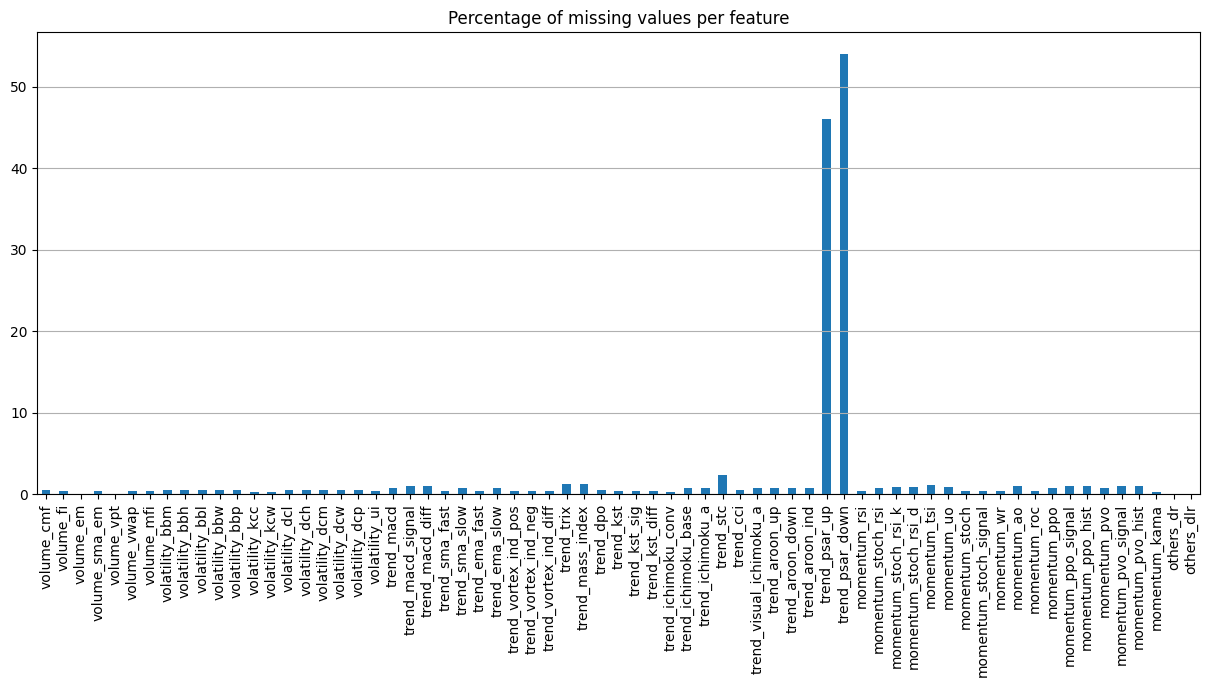

In [6]:
plt.figure(figsize = (15,6))
((df_features_indicators.isna().sum()\
  [df_features_indicators.isna().sum()>0]/df_features_indicators.shape[0]) * 100)\
.plot(kind='bar', title='Percentage of missing values per feature')
plt.grid(axis = 'y');


In [7]:
select_columns = list(set(df_features_indicators.columns) - set(["trend_psar_up", "trend_psar_down"]))

In [8]:
df_features_indicators_not_null = df_features_indicators[select_columns].dropna().copy()

In [9]:
df_features_indicators_not_null

,momentum_stoch_rsi_d,volume_adi,volatility_dcm,volatility_bbl,volume_cmf,trend_psar_up_indicator,trend_sma_slow,trend_psar_down_indicator,trend_adx_pos,momentum_ppo_hist,...,trend_ichimoku_base,trend_macd_signal,trend_kst_sig,volume_obv,momentum_ppo_signal,trend_kst_diff,momentum_ao,momentum_kama,volatility_ui,trend_macd
78,0.085557,5.696525e+06,272.864998,261.642332,1.0,0.0,275.203076,0.0,15.354051,-1.445561,...,266.144997,9.208765,182.999923,-894865,3.365013,-23.689058,9.931646,279.645198,5.306284,5.293379
79,0.024471,5.748177e+06,273.979996,262.295158,1.0,0.0,276.095384,0.0,14.635168,-1.678906,...,267.229996,8.063137,179.363098,-946517,2.945286,-38.120322,3.397089,275.841680,6.220296,3.480625
80,0.019543,5.804810e+06,273.979996,261.620207,1.0,0.0,277.255769,0.0,17.091712,-1.600910,...,267.229996,6.968886,172.873831,-889884,2.545059,-48.295139,-2.134557,275.179434,6.741881,2.591880
81,0.060198,5.886260e+06,273.979996,260.165367,1.0,0.0,278.462308,0.0,16.453755,-1.478008,...,267.229996,5.957728,164.060096,-808434,2.175557,-56.990262,-3.232349,274.730970,7.247529,1.913098
82,0.113271,6.037345e+06,271.814995,258.246730,1.0,0.0,279.571923,0.0,14.442030,-1.436140,...,268.329994,4.974422,153.108129,-959519,1.816522,-62.907763,-3.920996,273.982647,7.752107,1.041195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,0.080586,6.171862e+10,47751.804688,44533.868578,1.0,0.0,48695.980469,0.0,22.401851,-0.391318,...,47413.626953,2121.615849,174.834784,-11616954096,4.376313,18.456360,4935.712316,52296.552057,1.285997,1969.620273
3343,0.112202,6.171870e+10,48841.291016,45716.151271,1.0,1.0,49125.189153,0.0,31.002135,-0.124528,...,48394.785156,2117.934296,181.402166,-11616876042,4.345181,16.014231,4814.921886,52535.541291,1.285997,2103.208080
3344,0.301508,6.171880e+10,50945.832031,46492.355543,1.0,0.0,49674.885367,0.0,37.713049,0.326432,...,49913.867188,2173.505213,187.041814,-11616775565,4.426789,15.734809,5250.331135,53598.303062,1.285997,2395.788883
3345,0.577673,6.171897e+10,54584.787109,45682.257597,1.0,0.0,50461.655499,0.0,49.571621,1.290960,...,53093.916016,2359.819098,193.421556,-11616601925,4.749529,25.338618,6505.525034,56707.945246,1.285997,3105.074636


#Feature selection

<Axes: xlabel='date'>

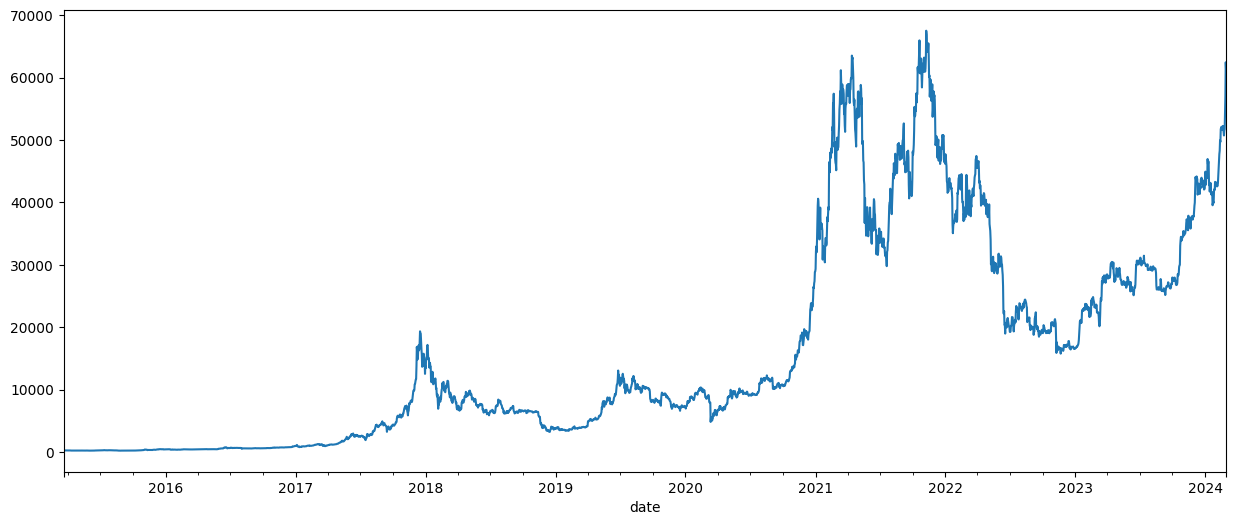

In [10]:
df_features_indicators_not_null.set_index("date").last_close.plot(figsize = (15,6))

In [11]:
df_features_indicators_not_null.set_index("date", inplace = True,drop=True)

In [12]:
X = df_features_indicators_not_null.drop(columns = ["last_close"])
y = df_features_indicators_not_null.last_close

In [13]:
pd.DataFrame(y).describe()

,last_close
count,3269.000000
mean,15954.347195
std,16655.488309
min,211.429993
25%,2446.050049
50%,9085.056641
75%,26857.462891
max,67527.851562


I want to predict 4 days ahead.


In [21]:
filter_test = X.index.max() - pd.Timedelta(days = 4)


In [28]:
train = y.loc[y.index < filter_test]
test = y.loc[y.index > filter_test]

In [29]:

days30 = train.index.max() - pd.Timedelta(days = 30)
days60 = train.index.max() - pd.Timedelta(days = 60)
days90 = train.index.max() - pd.Timedelta(days = 90)

In [30]:
train_30 = train.loc[train.index > days30]
train_60 = train.loc[train.index > days60]
train_90 = train.loc[train.index > days90]

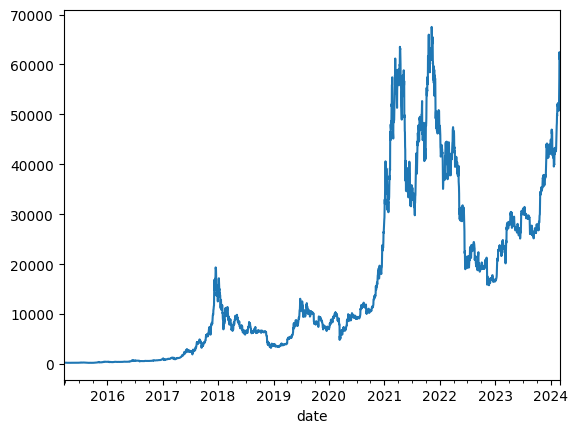

In [37]:
y.plot();

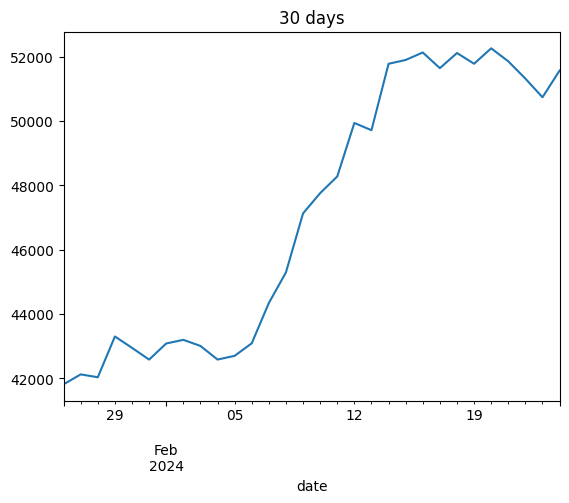

In [32]:
train_30.plot(title = '30 days');

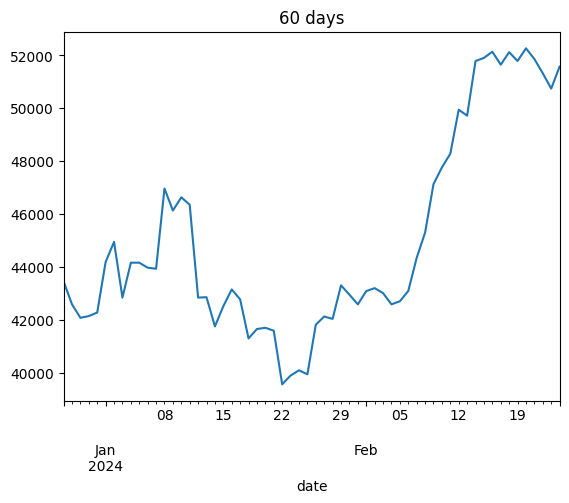

In [33]:
train_60.plot(title = '60 days');

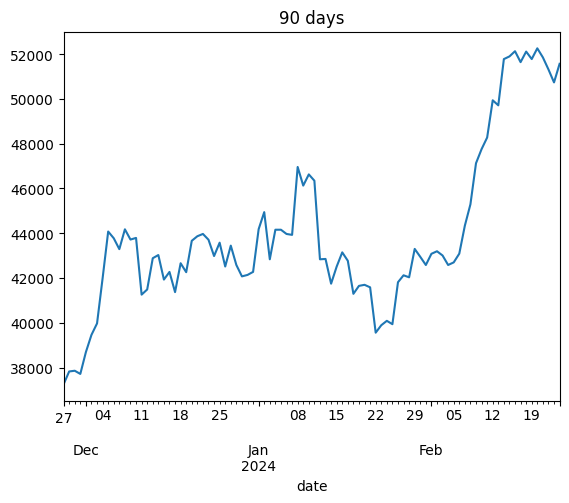

In [34]:
train_90.plot(title = '90 days');

In [50]:

info = dict()

for i in range(1,int(len(train_60)*1/4)+1):
  info.update({f'Lag {i}': train_60.autocorr(i)})
  

correlations = pd.DataFrame(pd.Series(info)).rename(columns = {0:'person_correlation'})

correlations
     

,Person Correlation
Lag 1,0.962772
Lag 2,0.927831
Lag 3,0.885434
Lag 4,0.832350
Lag 5,0.785817
Lag 6,0.740379
Lag 7,0.676349
Lag 8,0.606525
Lag 9,0.536614
Lag 10,0.445810


In [52]:
from src import utils

In [54]:

q_statistic, p_values = q_stat(correlations['Person Correlation'], len(train_60))
correlations['q_statistic'] = q_statistic.round(2)
correlations['prob_q'] = p_values.round(2)
correlations['random'] = correlations['prob_q'].apply(lambda p: utils.qstat_is_random(p))

In [55]:
correlations

,Person Correlation,q_statistic,prob_q,random
Lag 1,0.962772,58.44,0.0,False
Lag 2,0.927831,113.66,0.0,False
Lag 3,0.885434,164.82,0.0,False
Lag 4,0.832350,210.85,0.0,False
Lag 5,0.785817,252.61,0.0,False
Lag 6,0.740379,290.37,0.0,False
Lag 7,0.676349,322.48,0.0,False
Lag 8,0.606525,348.80,0.0,False
Lag 9,0.536614,369.80,0.0,False
Lag 10,0.445810,384.59,0.0,False


In [63]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            print("That time series is stationary? {0}".format(self.isStationary))

In [64]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(train_60, printResults = True)


Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.379059
P-Value                  0.913537
# Lags Used              0.000000
# Observations Used     59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64
That time series is stationary? False


In [84]:
train_60_diff = train_60.diff().dropna()

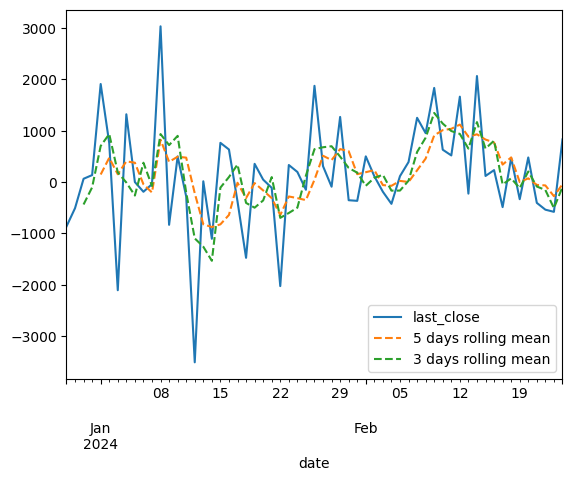

In [88]:
train_60_diff.plot()
train_60_diff.rolling(window = 5).mean().plot(label = '5 days rolling mean',style= '--')
train_60_diff.rolling(window = 3).mean().plot(label = '3 days rolling mean',style='--');    
plt.legend();

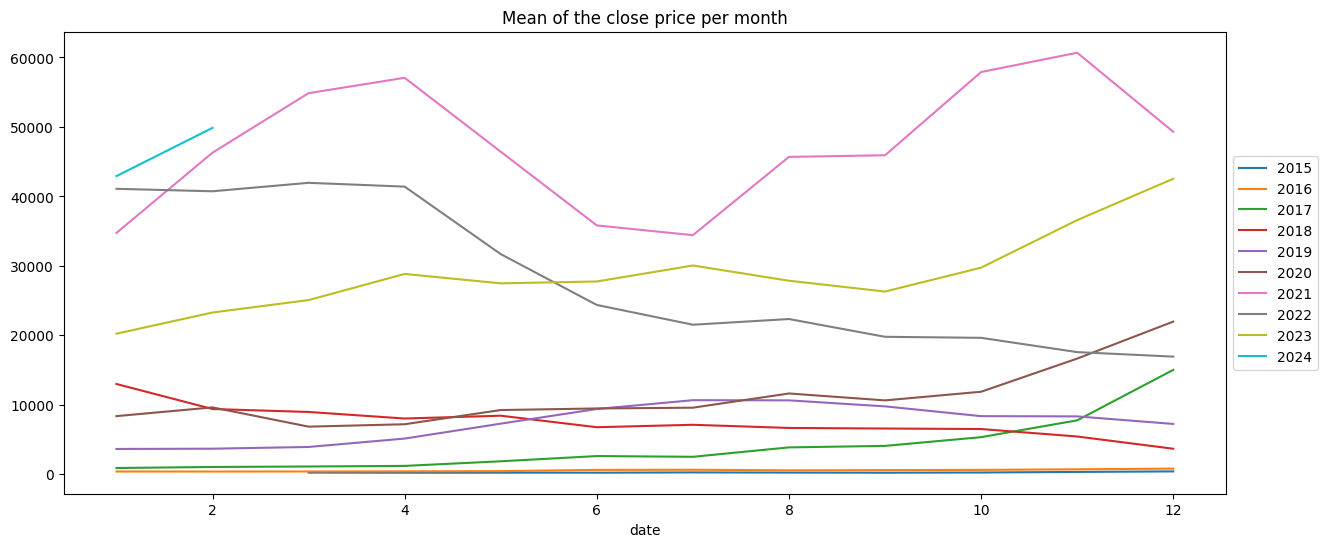

In [139]:
import matplotlib.pyplot as plt

# Assuming you already have the data and made the plot
data = y.groupby([y.index.year, y.index.month]).mean().reorder_levels([1, 0]).unstack()
ax = data.plot(kind='line', figsize=(15, 6), title='Mean of the close price per month')

# Adding a legend to the right side of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


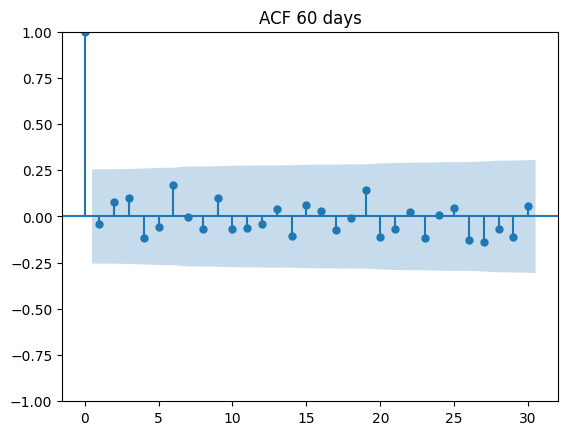

In [66]:
plot_acf(train_60.diff().dropna(), lags = 30, title = 'ACF 60 days');

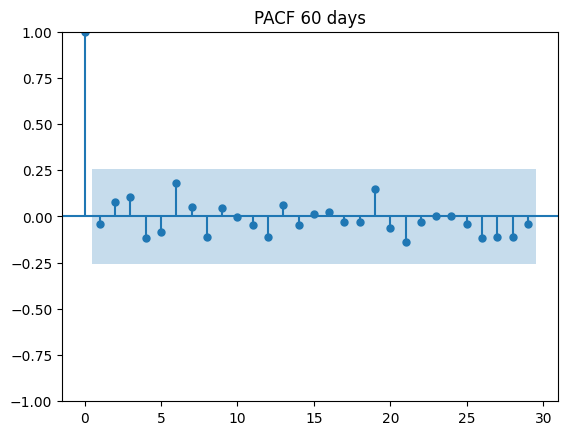

In [68]:
plot_pacf(train_60.diff().dropna(), lags = 29, title = 'PACF 60 days');

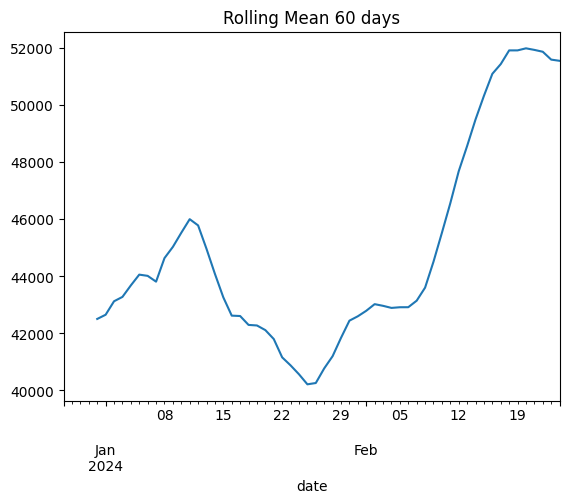

In [69]:
rolling_mean = train_60.rolling(window = 5).mean().plot(title = 'Rolling Mean 60 days');   

# Feature Selection


# vars original: 88, # vars com threshold: 78
[1.85890062e+02 5.81847358e+06 3.61915588e-01 7.27814727e+02
 3.65300873e+16 7.78655817e-02 2.27875333e+08 2.15578343e-01
 2.86421541e+08 7.75263661e+02 2.83170451e+08 1.32658278e-02
 1.14444351e-01 2.81819015e+08 3.13495141e+01 1.40543324e+20
 1.81788443e+15 3.59274780e-02 7.27814727e+02 1.83055911e+01
 1.96589674e+03 0.00000000e+00 2.76862836e+08 2.81549132e+04
 3.56443133e-02 7.84370367e+01 7.51706898e+04 2.77941727e+08
 2.02233403e+01 2.62140865e+08 2.67680139e+08 1.08389354e+01
 2.69548122e+08 2.41940229e+02 2.08357016e+08 2.23090332e+02
 2.72565133e+08 1.85407168e+02 2.87051575e+08 2.46743657e+03
 4.12082167e+01 1.07594847e+06 1.52417861e+00 2.81498617e+07
 4.25213417e-01 9.07969662e+05 2.60831932e+08 1.17768973e-01
 9.43795562e-02 6.24770563e+20 2.84758979e+08 1.17935961e+03
 2.69162586e+08 2.55455700e+08 3.41858775e+08 4.89608293e+02
 2.50206111e+08 1.45099831e+02 8.43467669e-02 4.31098127e+02
 1.32864017e+03 1.06053531e-01 6.802689

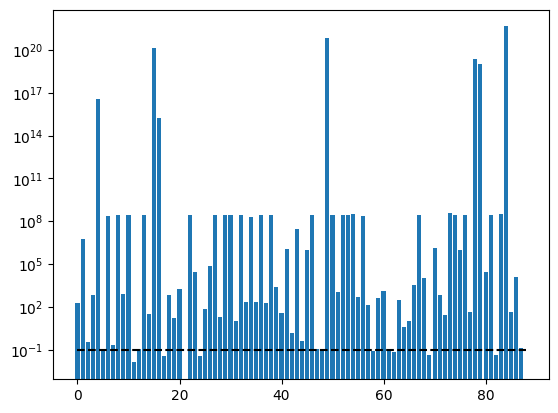

In [ ]:
threshold = 0.1
vt = VarianceThreshold(threshold)
X_vt = vt.fit_transform(X)


print('# vars original: {0}, # vars com threshold: {1}'.format(X.shape[1], X_vt.shape[1]))

fig, ax = plt.subplots()
ax.bar(range(len(vt.variances_)), vt.variances_)
ax.set_yscale('log')
ax.plot([0, len(vt.variances_)], [threshold, threshold], "k--")

print(vt.variances_)

In [ ]:
# Initialize SelectKBest with mutual_info_regression
skb_mi = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features

# Fit the SelectKBest to the data
X_selected = skb_mi.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = skb_mi.get_support(indices=True)

# Print the indices of the selected features
print("Indices of selected features:", selected_indices)

Indices of selected features: [ 8 29 32 36 43 52 54 67 74 81]


In [ ]:
X = X[X.columns[selected_indices]].copy()

In [ ]:
pd.concat([X,y],axis=1).corr()

,trend_ema_fast,last_min,trend_ichimoku_a,trend_ichimoku_conv,others_cr,volatility_dcm,volatility_dch,last_open,momentum_kama,last_max,last_close
trend_ema_fast,1.000000,0.995821,0.999392,0.999292,0.996999,0.998612,0.997090,0.997156,0.999426,0.996999,0.996075
last_min,0.995821,1.000000,0.995370,0.997125,0.998873,0.993410,0.990209,0.999064,0.996204,0.998873,0.999329
trend_ichimoku_a,0.999392,0.995370,1.000000,0.998956,0.995982,0.999396,0.996747,0.996181,0.998687,0.995982,0.995374
trend_ichimoku_conv,0.999292,0.997125,0.998956,1.000000,0.997700,0.997542,0.994842,0.997845,0.999204,0.997700,0.997169
others_cr,0.996999,0.998873,0.995982,0.997700,1.000000,0.994062,0.992744,0.999448,0.997423,1.000000,0.999454
volatility_dcm,0.998612,0.993410,0.999396,0.997542,0.994062,1.000000,0.997354,0.994309,0.997567,0.994062,0.993383
volatility_dch,0.997090,0.990209,0.996747,0.994842,0.992744,0.997354,1.000000,0.992209,0.996213,0.992744,0.991383
last_open,0.997156,0.999064,0.996181,0.997845,0.999448,0.994309,0.992209,1.000000,0.997526,0.999448,0.998788
momentum_kama,0.999426,0.996204,0.998687,0.999204,0.997423,0.997567,0.996213,0.997526,1.000000,0.997423,0.996534
last_max,0.996999,0.998873,0.995982,0.997700,1.000000,0.994062,0.992744,0.999448,0.997423,1.000000,0.999454


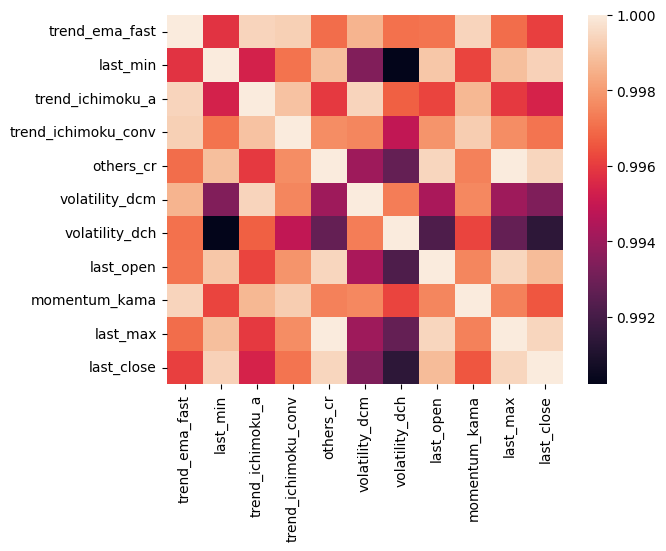

In [ ]:
sns.heatmap(pd.concat([X,y],axis=1).corr());